# ANN - Lab 2: Feed-forward nets for image classification

Tudor Berariu  
Skeleton code from https://github.com/tudor-berariu/ann2018

## 1. The MNIST dataset

In [1]:
#!pip install mnist

import mnist
train_imgs = mnist.train_images()
train_labels = mnist.train_labels()
test_imgs = mnist.test_images()
test_labels  = mnist.test_labels()

### Data standardization

Rescale input values to have zero mean and standard deviation of one.

In [2]:
mean, std  = train_imgs.mean(), train_imgs.std()
train_imgs = (train_imgs - mean) / std
test_imgs = (test_imgs - mean) / std

### See some inputs

In [3]:
from typing import List
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Labels: [4 2 6 0 4 4 3 0 0 5 7 1 7 1 2]


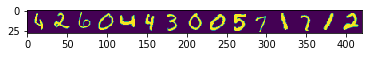

In [4]:
idxs = np.random.randint(0, len(train_imgs), 15)
imgs = np.concatenate(tuple(train_imgs[idx,:,:] for idx in idxs), axis=1)
plt.imshow(imgs)
print("Labels:", train_labels[idxs])

## 2. Building feed forward-networks

### Layers

Each layer will have three methods:
 - `forward` computes and returns ${\bf y}^{(l)} = f_l\left({\bf x}^{(l)}, {\bf w}^{(l)}\right)$
 - `backward` gets $\frac{\partial {\cal L}}{\partial {\bf y}^{(l)}}$, and stores $\frac{\partial {\cal L}}{\partial {\bf w}^{(l)}}$ internally, and returns $\frac{\partial {\cal L}}{\partial {\bf w}^{(l)}}$
 - `update` modifies parameters ${\bf w}^{(l)}$ using stored $\frac{\partial{\cal L}}{\partial{\bf w}}$

In [5]:
class Layer:

    def forward(self, x: np.ndarray) -> np.ndarray:
        raise NotImplementedError
        
    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        raise NotImplementedError
        
    def update(self, *args, **kwargs):
        pass  # If a layer has no parameters, then this function does nothing

### The feed-forward netowork

In [6]:
class FeedForwardNetwork:
    
    def __init__(self, layers: List[Layer]):
        self.layers = layers
        
    def forward(self, x: np.ndarray, train: bool = True) -> np.ndarray:
        self._inputs = []
        for layer in self.layers:
            if train:
                self._inputs.append(x)
            x = layer.forward(x)
        return x
    
    def backward(self, dy:np.ndarray) -> np.ndarray:
        # TODO <0> : Compute the backward phase
        for idx in reversed(range(len(self._inputs))):
            x = self._inputs[idx]
            layer = self.layers[idx]
            dy = layer.backward(x, dy)
        del self._inputs
        return dy
    
    def update(self, *args, **kwargs):
        for layer in self.layers:
            layer.update(*args, **kwargs)

### The linear layer

In [7]:
class Linear(Layer):
    
    def __init__(self, insize: int, outsize: int) -> None:
        bound = np.sqrt(6. / insize)
        self.weight = np.random.uniform(-bound, bound, (insize, outsize))
        self.bias = np.zeros((outsize,))
        
        self.dweight = np.zeros_like(self.weight)
        self.dbias = np.zeros_like(self.bias)
        
        self.weight_v = np.zeros_like(self.weight)
        self.dweight_cache = np.zeros_like(self.dweight)
        self.bias_v = np.zeros_like(self.bias)
        self.dbias_cache = np.zeros_like(self.dbias)
        
    def forward(self, x: np.ndarray) -> np.ndarray:
        # TODO <1> : compute the output of a linear layer
        return np.dot(x, self.weight) + self.bias
    
    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        # TODO <2> : compute dweight, dbias and  return dx
        self.dweight = np.dot(x.T, dy)
        self.dbias = np.sum(dy, axis=0)
        self.dx = np.dot(dy, self.weight.T)
        return self.dx
    
    def update(self, mode='SGD', lr=0.001, mu=.9, beta1=.9, beta2=.999):
        if mode == 'SGD':
            self.weight -= lr * self.dweight
            self.bias -= lr * self.dbias
        elif mode == 'Nesterov':
            # TODO <9> : compute the nesterov update (for Lab 2)
            weight_v_prev = self.weight_v.copy()
            bias_v_prev = self.bias_v.copy()
            
            self.weight_v = mu * self.weight_v - lr * self.dweight
            self.bias_v = mu * self.bias_v - lr * self.dbias
            
            self.weight += -mu * weight_v_prev + (1 + mu) * self.weight_v
            self.bias += -mu * bias_v_prev + (1 + mu) * self.bias_v
            
            del weight_v_prev
            del bias_v_prev
        elif mode == 'Adam':
            # TODO <10> : compute the Adam update  (for Lab 2)
            self.weight_v = beta1 * self.weight_v + (1 - beta1) * self.dweight
            self.dweight_cache = beta2 * self.dweight_cache + (1 - beta2) * self.dweight ** 2
            
            self.bias_v = beta1 * self.bias_v + (1 - beta1) * self.dbias
            self.dbias_cache = beta2 * self.dbias_cache + (1 - beta2) * self.dbias ** 2
            
            self.weight -= lr * self.weight_v / (1e-8 + np.sqrt(self.dweight_cache))
            self.bias -= lr * self.bias_v / (1e-8 + np.sqrt(self.dbias_cache))

### The Rectified Linear Unit
$$y = \max\left(x, 0\right)$$

In [8]:
class ReLU(Layer):
    
    def __init__(self) -> None:
        pass
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        # TODO <3> : Compute the output of a rectified linear unit
        return np.maximum(x, 0)
    
    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        # TODO <4> : Compute the gradient w.r.t. x
        return (x > 0) * dy

## 3. The loss function

   The negative log likelihood combines a softmax activation, and a cross-entropy cost.

In [9]:
class NegativeLogLikelihood:
    
    def __init__(self):
        pass

    def forward(self, y: np.ndarray, t: np.ndarray) -> float:
        # TODO <5> : Compute the negative log likelihood
        self._N = y.shape[0]
        shifted_logits = y - np.max(y, axis=1, keepdims=True)
        Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
        self._log_probs = shifted_logits - np.log(Z)
        loss = -np.sum(self._log_probs[np.arange(self._N), t]) / self._N
        return loss
    
    def backward(self, y: np.ndarray, t: np.ndarray) -> np.ndarray:
        # TODO <6> : Compute dl/dy
        dy = np.exp(self._log_probs)
        dy[np.arange(self._N), t] -= 1
        dy /= self._N
        return dy

### Accuracy

In [10]:
def accuracy(y: np.ndarray, t: np.ndarray) -> float:
    # TODO <7> : Compute accuracy
    return np.sum(np.argmax(y, axis=1) == t) / np.float64(t.size)

## 4. Training a neural network

In [11]:
def train_a_neural_net(optimize_args = {'mode': 'SGD', 'lr': .001}):
    BATCH_SIZE = 128
    HIDDEN_UNITS = 200
    EPOCHS_NO = 50

    net = FeedForwardNetwork([Linear(784, HIDDEN_UNITS),
                              ReLU(),
                              Linear(HIDDEN_UNITS, 10)])
    nll = NegativeLogLikelihood()

    for epoch in range(EPOCHS_NO):
        for b_no, idx in enumerate(range(0, len(train_imgs), BATCH_SIZE)):
            # 1. Prepare next batch
            x = train_imgs[idx:idx + BATCH_SIZE,:,:].reshape(-1, 784)
            t = train_labels[idx:idx + BATCH_SIZE]

            # forward
            y = net.forward(x, train=True)

            # 2. Compute gradient
            # TODO <8> : Compute gradient
            loss = nll.forward(y, t)
            dy = nll.backward(y, t)
            net.backward(dy)

            # 3. Update network parameters
            net.update(**optimize_args)

            print(f'\rEpoch {epoch + 1:02d} '
                  f'| Batch {b_no:03d} '
                  f'| Train NLL: {loss:3.5f} '
                  f'| Train Accuracy: {accuracy(y, t):3.2f} ', end='')

        y = net.forward(test_imgs.reshape(-1, 784), train=False)
        test_nll = nll.forward(y, test_labels)
        print(f' | Test NLL: {test_nll:3.5f} '
              f' | Test Accuracy: {accuracy(y, test_labels):3.2f}')

In [12]:
train_a_neural_net(optimize_args = {'mode': 'SGD', 'lr': .001})

Epoch 01 | Batch 468 | Train NLL: 1.03884 | Train Accuracy: 0.72  | Test NLL: 0.89364  | Test Accuracy: 0.74
Epoch 02 | Batch 468 | Train NLL: 0.73349 | Train Accuracy: 0.81  | Test NLL: 0.62246  | Test Accuracy: 0.82
Epoch 03 | Batch 468 | Train NLL: 0.60450 | Train Accuracy: 0.88  | Test NLL: 0.51502  | Test Accuracy: 0.86
Epoch 04 | Batch 468 | Train NLL: 0.53322 | Train Accuracy: 0.88  | Test NLL: 0.45650  | Test Accuracy: 0.87
Epoch 05 | Batch 468 | Train NLL: 0.48780 | Train Accuracy: 0.89  | Test NLL: 0.41904  | Test Accuracy: 0.88
Epoch 06 | Batch 468 | Train NLL: 0.45604 | Train Accuracy: 0.89  | Test NLL: 0.39252  | Test Accuracy: 0.89
Epoch 07 | Batch 468 | Train NLL: 0.43235 | Train Accuracy: 0.90  | Test NLL: 0.37246  | Test Accuracy: 0.90
Epoch 08 | Batch 468 | Train NLL: 0.41374 | Train Accuracy: 0.90  | Test NLL: 0.35653  | Test Accuracy: 0.90
Epoch 09 | Batch 468 | Train NLL: 0.39857 | Train Accuracy: 0.90  | Test NLL: 0.34345  | Test Accuracy: 0.90
Epoch 10 | Batch 46

In [13]:
train_a_neural_net(optimize_args = {'mode': 'Nesterov', 'lr': .001, 'mu': .9})

Epoch 01 | Batch 468 | Train NLL: 0.39991 | Train Accuracy: 0.90  | Test NLL: 0.33342  | Test Accuracy: 0.91
Epoch 02 | Batch 468 | Train NLL: 0.31126 | Train Accuracy: 0.95  | Test NLL: 0.26977  | Test Accuracy: 0.92
Epoch 03 | Batch 468 | Train NLL: 0.27299 | Train Accuracy: 0.96  | Test NLL: 0.23772  | Test Accuracy: 0.93
Epoch 04 | Batch 468 | Train NLL: 0.24892 | Train Accuracy: 0.96  | Test NLL: 0.21581  | Test Accuracy: 0.94
Epoch 05 | Batch 468 | Train NLL: 0.23220 | Train Accuracy: 0.97  | Test NLL: 0.19936  | Test Accuracy: 0.94
Epoch 06 | Batch 468 | Train NLL: 0.22012 | Train Accuracy: 0.98  | Test NLL: 0.18627  | Test Accuracy: 0.94
Epoch 07 | Batch 468 | Train NLL: 0.21086 | Train Accuracy: 0.99  | Test NLL: 0.17555  | Test Accuracy: 0.95
Epoch 08 | Batch 468 | Train NLL: 0.20321 | Train Accuracy: 0.99  | Test NLL: 0.16650  | Test Accuracy: 0.95
Epoch 09 | Batch 468 | Train NLL: 0.19691 | Train Accuracy: 0.99  | Test NLL: 0.15867  | Test Accuracy: 0.95
Epoch 10 | Batch 46

In [14]:
train_a_neural_net(optimize_args = {'mode': 'Adam', 'lr': .001, 'beta1': .9, 'beta2': .999})

Epoch 01 | Batch 468 | Train NLL: 0.23781 | Train Accuracy: 0.98  | Test NLL: 0.11951  | Test Accuracy: 0.96
Epoch 02 | Batch 468 | Train NLL: 0.21647 | Train Accuracy: 0.99  | Test NLL: 0.09735  | Test Accuracy: 0.97
Epoch 03 | Batch 468 | Train NLL: 0.20542 | Train Accuracy: 0.99  | Test NLL: 0.09077  | Test Accuracy: 0.97
Epoch 04 | Batch 468 | Train NLL: 0.17588 | Train Accuracy: 0.99  | Test NLL: 0.08892  | Test Accuracy: 0.97
Epoch 05 | Batch 468 | Train NLL: 0.14915 | Train Accuracy: 0.99  | Test NLL: 0.08563  | Test Accuracy: 0.97
Epoch 06 | Batch 468 | Train NLL: 0.13172 | Train Accuracy: 0.99  | Test NLL: 0.08606  | Test Accuracy: 0.97
Epoch 07 | Batch 468 | Train NLL: 0.11468 | Train Accuracy: 0.99  | Test NLL: 0.08984  | Test Accuracy: 0.97
Epoch 08 | Batch 468 | Train NLL: 0.08705 | Train Accuracy: 0.99  | Test NLL: 0.09253  | Test Accuracy: 0.97
Epoch 09 | Batch 468 | Train NLL: 0.08447 | Train Accuracy: 0.99  | Test NLL: 0.08855  | Test Accuracy: 0.98
Epoch 10 | Batch 46